#### Sociology 128D: Mining Culture Through Text Data: Introduction to Social Data Science

# Notebook 3: Stylometry

In this notebook, we are going to take our first step toward topics such as [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics), [vector space models](https://en.wikipedia.org/wiki/Vector_space_model), and [vector semantics](https://web.stanford.edu/~jurafsky/slp3/6.pdf). This involves quantifying information about linguistic units (whether individual words or entire documents) within the context of information about the entire corpus in order to [learn representations](https://en.wikipedia.org/wiki/Feature_learning) of the linguistic units as vectors of numbers. The vectors of numbers may have relatively few dimensions (e.g., 50) or may have many thousands. The vectors representing words, documents, parts of documents, or even latent dimensions can then be mathematically compared to measure the similarity of different things. Words used in similar ways (i.e., used with similar context words) will have similar vectors in a model of word embeddings. Documents that use similar language will also have similar vectors in a model of documents. We're going to start by exploring similarity among documents, which we'll return to in Notebook 5. We will turn to [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) in Notebooks 9 and 10.

More broadly, taken together, these ideas are one of the main approaches we'll use in this class. They have exerted enormous influence on computational social science, including within cultural sociology. Specifically, in this notebook we will build on Notebook 2 by using word and document frequencies to visualize how similar or dissimilar documents are.

Please download the [State of the Union Corpus (1790-2018)](https://www.kaggle.com/rtatman/state-of-the-union-corpus-1989-2017), which was posted to Kaggle by Rachael Tatman and Liling Tan. 

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import Counter
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

sns.set_theme(style="darkgrid")

First things first: There are a lot of speeches in this *corpus* (collection of documents), and we have to put them somewhere. For Notebooks 1 and 2, I encouraged you to keep datasets in your working directory—where Jupyter looks automatically—to keep things simple. If we do that this time, though, we'll have hundreds of individual text files in the same directory as your notebooks, and that would be a mess to look through later. I'm simply creating a variable called `dir_` (short for "directory") that stores the location of the speeches as a string variable. (`dir_` has an underscore on the end because `dir` without an underscore is a reserved keyword in Python.)

Modify `dir_` to point to where you have saved the State of the Union addresses. I'm using a relative path: a path from my working directory to the data. I have a folder for the notebooks, and within that folder there is a folder called `data`. Within *that* folder, I have a folder called `sotu` containing the speeches. Since my working directory is the directory in which I have both the notebooks *and* the `data` folder (which contains the `sotu` folder), I only need to tell Jupyter to look in `data/sotu/` for the files.

In [2]:
print(os.getcwd())

C:\Users\case\Dropbox\github\soc128d\notebooks


In [3]:
dir_ = "data/sotu/"
os.listdir(dir_)

['Adams_1797.txt',
 'Adams_1798.txt',
 'Adams_1799.txt',
 'Adams_1800.txt',
 'Adams_1825.txt',
 'Adams_1826.txt',
 'Adams_1827.txt',
 'Adams_1828.txt',
 'Arthur_1881.txt',
 'Arthur_1882.txt',
 'Arthur_1883.txt',
 'Arthur_1884.txt',
 'Buchanan_1857.txt',
 'Buchanan_1858.txt',
 'Buchanan_1859.txt',
 'Buchanan_1860.txt',
 'Buren_1837.txt',
 'Buren_1838.txt',
 'Buren_1839.txt',
 'Buren_1840.txt',
 'Bush_1989.txt',
 'Bush_1990.txt',
 'Bush_1991.txt',
 'Bush_1992.txt',
 'Bush_2001.txt',
 'Bush_2002.txt',
 'Bush_2003.txt',
 'Bush_2004.txt',
 'Bush_2005.txt',
 'Bush_2006.txt',
 'Bush_2007.txt',
 'Bush_2008.txt',
 'Carter_1978.txt',
 'Carter_1979.txt',
 'Carter_1980.txt',
 'Carter_1981.txt',
 'Cleveland_1885.txt',
 'Cleveland_1886.txt',
 'Cleveland_1887.txt',
 'Cleveland_1888.txt',
 'Cleveland_1893.txt',
 'Cleveland_1894.txt',
 'Cleveland_1895.txt',
 'Cleveland_1896.txt',
 'Clinton_1993.txt',
 'Clinton_1994.txt',
 'Clinton_1995.txt',
 'Clinton_1996.txt',
 'Clinton_1997.txt',
 'Clinton_1998.txt'

`dir_` points to the *directory* (or folder) in which the speeches are stored, but we also want to be able to tell Python the names of the files. [`os.path.join` (link)](https://www.geeksforgeeks.org/python-os-path-join-method/) is a clean way of merging file paths with file names. The line of code below is a list comprehension that iterates through every file in `dir_`, checks the file extension, keeps those that end with the proper extension, and joins the file path to the file name. The result is a list we can use to tell Python exactly where each file is by name.

In [4]:
sotu_paths = [os.path.join(dir_, f) for f in os.listdir(dir_) if f.endswith(".txt")]

In [5]:
sotu_paths[0]

'data/sotu/Adams_1797.txt'

In [8]:
# print(open(sotu_paths[0], "r").read())

The function defined below takes a single parameter (`f`) that should be a string variable containing the file path and name of the text file for a given speech. This function will `open()` the file, use `os.path.split` to take the *last* element (just the file name, excluding the path), remove the file extension, and then split the file name on underscores. Because the files are named things like `Adams_1797.txt`, we can split on underscores after these other steps to get the name of the president who gave the speech (e.g., Adams) and the year in which it was given (e.g., 1797). The function returns the president, the year, and the text of the speech.

In [6]:
def return_sotu_name_year_text(f: str):
    """Returns the name, year, and text of a SOTU."""
    doc = open(f, "r").read().strip()
    f = os.path.split(f)[-1]
    f = f.rstrip(".txt")
    pres, year = f.split("_")
    return pres, year, doc

In [7]:
return_sotu_name_year_text(sotu_paths[0])

('Adams',
 '1797',
 'Gentlemen of the Senate and Gentlemen of the House of Representatives:\n\nI was for some time apprehensive that it would be necessary, on account of\nthe contagious sickness which afflicted the city of Philadelphia, to\nconvene the National Legislature at some other place. This measure it was\ndesirable to avoid, because it would occasion much public inconvenience and\na considerable public expense and add to the calamities of the inhabitants\nof this city, whose sufferings must have excited the sympathy of all their\nfellow citizens. Therefore, after taking measures to ascertain the state\nand decline of the sickness, I postponed my determination, having hopes,\nnow happily realized, that, without hazard to the lives or health of the\nmembers, Congress might assemble at this place, where it was next by law to\nmeet. I submit, however, to your consideration whether a power to postpone\nthe meeting of Congress, without passing the time fixed by the Constitution\nupo

Next, we are going to store all of the speeches (along with metadata, such as the president and year) as a dataframe. We can do that in a number of ways. The cell below uses a [for loop](https://cs.stanford.edu/people/nick/py/python-for.html) to iterate through all of the file paths in our list of file paths (`sotu_paths`), calls the function we just defined to get the president, year, and text, and then appends each of these elements to a separate list. The code then uses `zip` to combine these lists and converts the result to a dataframe.

In [8]:
presidents = []
years = []
docs = []

for path in sotu_paths:
    pres, year, doc = return_sotu_name_year_text(path)
    presidents.append(pres)
    years.append(year)
    docs.append(doc)
    
data = list(zip(presidents, years, docs))

pd.DataFrame(data, columns = ["president", "year", "text"])

,president,year,text
0,Adams,1797,Gentlemen of the Senate and Gentlemen of the H...
1,Adams,1798,Gentlemen of the Senate and Gentlemen of the H...
2,Adams,1799,Gentlemen of the Senate and Gentlemen of the H...
3,Adams,1800,Gentlemen of the Senate and Gentlemen of the H...
4,Adams,1825,Fellow Citizens of the Senate and of the House...
...,...,...,...
223,Wilson,1916,GENTLEMEN OF THE CONGRESS:\n\nIn fulfilling at...
224,Wilson,1917,GENTLEMEN OF THE CONGRESS:\n\nEight months hav...
225,Wilson,1918,GENTLEMEN OF THE CONGRESS:\n\nThe year that ha...
226,Wilson,1919,TO THE SENATE AND HOUSE OF REPRESENTATIVES:\n\...


The cell below accomplishes the same task, but it does so a bit differently. It first creates a dataframe called `df` with only the file paths in our list of file paths. It then uses the `apply()` method to call the function we defined above to each file path, creating new columns in the process. It then drops the file_path column.

In [9]:
df = pd.DataFrame(sotu_paths, columns = ["file_path"])
df[["president", "year", "text"]] = df.file_path.apply(lambda x: pd.Series(return_sotu_name_year_text(x)))
df.drop(columns = ["file_path"], inplace = True)

df

,president,year,text
0,Adams,1797,Gentlemen of the Senate and Gentlemen of the H...
1,Adams,1798,Gentlemen of the Senate and Gentlemen of the H...
2,Adams,1799,Gentlemen of the Senate and Gentlemen of the H...
3,Adams,1800,Gentlemen of the Senate and Gentlemen of the H...
4,Adams,1825,Fellow Citizens of the Senate and of the House...
...,...,...,...
223,Wilson,1916,GENTLEMEN OF THE CONGRESS:\n\nIn fulfilling at...
224,Wilson,1917,GENTLEMEN OF THE CONGRESS:\n\nEight months hav...
225,Wilson,1918,GENTLEMEN OF THE CONGRESS:\n\nThe year that ha...
226,Wilson,1919,TO THE SENATE AND HOUSE OF REPRESENTATIVES:\n\...


The cell below will sort the speeches by the year in which they were given and then reset the index (i.e., the numbers on the lefthand side), which is based on ordering the rows alphabetically by the president's name.

In [10]:
df.sort_values(by="year", inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,president,year,text
0,Washington,1790,
1,Washington,1791,Fellow-Citizens of the Senate and House of Rep...
2,Washington,1792,Fellow-Citizens of the Senate and House of Rep...
3,Washington,1793,Fellow-Citizens of the Senate and House of Rep...
4,Washington,1794,Fellow-Citizens of the Senate and House of Rep...


In [11]:
?df.reset_index

There's no text for the row for 1790, so we will use the `drop()` method to get rid of that row using its index, which is 0 since it is the first and Python begins from 0.

In [12]:
df.drop(index=0, inplace = True)
df.reset_index(inplace=True, drop=True)
df.head()

,president,year,text
0,Washington,1791,Fellow-Citizens of the Senate and House of Rep...
1,Washington,1792,Fellow-Citizens of the Senate and House of Rep...
2,Washington,1793,Fellow-Citizens of the Senate and House of Rep...
3,Washington,1794,Fellow-Citizens of the Senate and House of Rep...
4,Washington,1795,Fellow-Citizens of the Senate and House of Rep...


There are many presidents who have the same last names. This is a bit of a problem if we want to compare the speeches from different presidents. We need to disambiguate the names.

In [13]:
df[df.president=="Adams"]

,president,year,text
6,Adams,1797,Gentlemen of the Senate and Gentlemen of the H...
7,Adams,1798,Gentlemen of the Senate and Gentlemen of the H...
8,Adams,1799,Gentlemen of the Senate and Gentlemen of the H...
9,Adams,1800,Gentlemen of the Senate and Gentlemen of the H...
34,Adams,1825,Fellow Citizens of the Senate and of the House...
35,Adams,1826,Fellow Citizens of the Senate and of the House...
36,Adams,1827,Fellow Citizens of the Senate and of the House...
37,Adams,1828,Fellow Citizens of the Senate and of the House...


The cell below demonstrates that we can use a question mark to look up information about all sorts of things, in this case the `np.where()` method. We can use question marks or doc strings to look at documentation without having to leave the notebook, although searching the internet for ways to do things is natural.

We are going to use `np.where()` to identify locations where presidents have a certain last name (e.g., Adams) in a certain time period (e.g., after 1800). Since time has the useful property of appearing to be linear and there are only a handful of US presidents who share names with earlier US presidents, we can manually disambiguate the names of the presidents who share names.

In [16]:
?np.where

In [15]:
print(np.where.__doc__)


    where(condition, [x, y])

    Return elements chosen from `x` or `y` depending on `condition`.

    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.

    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.

    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.

    See Also
    --------
    choose
    nonzero : The function that is called when x and y are omitted

    Notes
    -----
    If all the arrays are 1-D, `where

The cell below looks complicated, but if you clean data in this way it'll become familiar. There are three parts to our call to `np.where()`: the *conditions*, the name (a string) we want to replace the value with if the conditions are `True`, and the value we want to use if the conditions are `False`. The cell below identifies rows with "Adams" in the president column and a year greater than 1800. The second US president, John Adams, gave State of the Union addresses in 1797, 1798, 1799, and 1800. His son, John Quincy Adams, was the sixth US president and gave all his state of the union addresses *after* 1800.

In [17]:
df.year = df.year.apply(int)
df.president = np.where(df.president.eq("Adams") & df["year"].gt(1800), "Adams2", df.president)

In [18]:
df[df.president=="Adams"]

,president,year,text
6,Adams,1797,Gentlemen of the Senate and Gentlemen of the H...
7,Adams,1798,Gentlemen of the Senate and Gentlemen of the H...
8,Adams,1799,Gentlemen of the Senate and Gentlemen of the H...
9,Adams,1800,Gentlemen of the Senate and Gentlemen of the H...


In [19]:
df[df.president=="Adams2"]

,president,year,text
34,Adams2,1825,Fellow Citizens of the Senate and of the House...
35,Adams2,1826,Fellow Citizens of the Senate and of the House...
36,Adams2,1827,Fellow Citizens of the Senate and of the House...
37,Adams2,1828,Fellow Citizens of the Senate and of the House...


We also need to distinguish George W. Bush from George H.W. Bush, Andrew Johnson (served 1865-1869) from Lyndon Johnson (served 1963-1969), and Theodore Roosevelt (served 1901-1909) from Franklin Roosevelt (served 1933-1945).

We don't need to distinguish William Henry Harrison from Benjamin Harrison because the former never gave a State of the Union address.

In [20]:
df.president = np.where(df.president.eq("Bush") & df["year"].gt(2000), "Bush2", df.president)
df.president = np.where(df.president.eq("Johnson") & df["year"].gt(1900), "Johnson2", df.president)
df.president = np.where(df.president.eq("Roosevelt") & df["year"].gt(1930), "Roosevelt2", df.president)

We can call the `unique()` method on a column to see the distinct values. There are only 42 presidents here because the dataset stops at 2018 (excluding Biden), two presidents did not give state of the union addresses (William Henry Harrison and James A. Garfield), and Grover Cleveland held non-consecutive terms as the 22nd and 24th president.

In [21]:
df.president.unique()

array(['Washington', 'Adams', 'Jefferson', 'Madison', 'Monroe', 'Adams2',
       'Jackson', 'Buren', 'Tyler', 'Polk', 'Taylor', 'Fillmore',
       'Pierce', 'Buchanan', 'Lincoln', 'Johnson', 'Grant', 'Hayes',
       'Arthur', 'Cleveland', 'Harrison', 'McKinley', 'Roosevelt', 'Taft',
       'Wilson', 'Harding', 'Coolidge', 'Hoover', 'Roosevelt2', 'Truman',
       'Eisenhower', 'Kennedy', 'Johnson2', 'Nixon', 'Ford', 'Carter',
       'Reagan', 'Bush', 'Clinton', 'Bush2', 'Obama', 'Trump'],
      dtype=object)

In [22]:
len(df.president.unique())

42

Now we will do some pretty crude *preprocessing* of the text itself. Specifically, we are going to lowercase all of the text, remove non-alphabetical characters (like punctuation and numbers), and then *tokenize* by splitting on whitespace.

In [23]:
df.text = df.text.apply(str.lower)

In [24]:
df.head()

,president,year,text
0,Washington,1791,fellow-citizens of the senate and house of rep...
1,Washington,1792,fellow-citizens of the senate and house of rep...
2,Washington,1793,fellow-citizens of the senate and house of rep...
3,Washington,1794,fellow-citizens of the senate and house of rep...
4,Washington,1795,fellow-citizens of the senate and house of rep...


The built-in `ord()` function provides the unicode code for a given character. We can use it to identify the range of the letters in the alphabet we are using (i.e., the number for "a" and the number for "z") as well as the number for spaces, which we also want to keep prior to splitting documents on them.

In [25]:
?ord

In [26]:
print(f'a = {ord("a")}, z = {ord("z")}, and space = {ord(" ")}')

a = 97, z = 122, and space = 32


The cell below demonstrates how this works by iterating through characters in the string variable `s`, checking whether each is a space or is in the range we identified, and either adding the character (if we want to keep it) or a space (if we don't) to a new string variable, `s2`.

In [27]:
s = "This is a test string, and it has some punctuation--not a lot, but some--that we're going to remove."

s2 = ""
for char in s.lower():
    if (char == " ") or (ord(char) in range(97,123)):
        s2 += char
    else:
        s2 += " "
        
print(s2)
print() # this gives us a blank line

print(s2.split())

this is a test string  and it has some punctuation  not a lot  but some  that we re going to remove 

['this', 'is', 'a', 'test', 'string', 'and', 'it', 'has', 'some', 'punctuation', 'not', 'a', 'lot', 'but', 'some', 'that', 'we', 're', 'going', 'to', 'remove']


Below, we define a function called `keep_alphabetical()` that preserves only spaces and lowercase letters a through z.  Later we will do this kind of thing using [regular expressions](https://en.wikipedia.org/wiki/Regular_expression), but we'll keep it simple for now. We then use the `apply()` method to apply this function to the text column.

In [28]:
def keep_alphabetical(text: str) -> str:
    """Keep only lowercase a-z"""
    return "".join([char if (ord(char) in range(97,123) or char == " ") else " " for char in text])


df.text = df.text.apply(keep_alphabetical)

In [29]:
df

,president,year,text
0,Washington,1791,fellow citizens of the senate and house of rep...
1,Washington,1792,fellow citizens of the senate and house of rep...
2,Washington,1793,fellow citizens of the senate and house of rep...
3,Washington,1794,fellow citizens of the senate and house of rep...
4,Washington,1795,fellow citizens of the senate and house of rep...
...,...,...,...
222,Obama,2014,mr speaker mr vice president members of co...
223,Obama,2015,mr speaker mr vice president members of co...
224,Obama,2016,mr speaker mr vice president members of co...
225,Trump,2017,thank you very much mr speaker mr vice pre...


## Word Frequencies over the Entire Corpus

Let's take a look at how frequent different words are in the corpus as a whole. First, we're going to select the column in our dataframe that has the text of the speeches. Right now, each row just has a string for that column containing the text of a speech. We're going to connect them all together using whitespace and the `join()` method.

This will create one mega document that combines all of the documents in the corpus; we'll then split on whitespace and use `Counter()` like we did last week. Since `Counter()` saves the result as a special counter object by default, we'll cast it as a `dict` and save the result in a variable called `word_frequencies`. This will be a word-to-frequency mapping where the keys are words and the values are the total frequency of each word in the whole corpus.

After that, we'll create another variable to store a list of `tuples` containing a word and its frequency. We'll sort that in descending order based on the frequency using a common lambda function.

In [30]:
all_text = " ".join(df.text)

word_frequencies = dict(Counter(all_text.split()))

In [32]:
all_text[:10000]

'fellow citizens of the senate and house of representatives    in vain may we expect peace with the indians on our frontiers so long as a lawless set of unprincipled wretches can violate the rights of hospitality  or infringe the most solemn treaties  without receiving the punishment they so justly merit    i meet you upon the present occasion with the feelings which are naturally inspired by a strong impression of the prosperous situations of our common country  and by a persuasion equally strong that the labors of the session which has just commenced will  under the guidance of a spirit no less prudent than patriotic  issue in measures conducive to the stability and increase of national prosperity   numerous as are the providential blessings which demand our grateful acknowledgments  the abundance with which another year has again rewarded the industry of the husbandman is too important to escape recollection   your own observations in your respective situations will have satisfied y

In [36]:
# word_frequencies.items()

In [37]:
types_and_counts = sorted(list(word_frequencies.items()), reverse = True, key = lambda x: x[1])
print(types_and_counts[:20])

[('the', 149615), ('of', 96394), ('and', 60703), ('to', 60642), ('in', 38521), ('a', 28034), ('that', 21946), ('for', 18954), ('be', 18588), ('our', 17265), ('is', 16932), ('it', 15494), ('by', 14960), ('we', 12624), ('which', 12270), ('as', 12158), ('this', 12011), ('have', 12009), ('with', 11984), ('i', 9514)]


In [38]:
print(f"The corpus has {sum(word_frequencies.values()):,} total words and a vocabulary of size {len(word_frequencies.keys()):,}.") 

The corpus has 1,762,236 total words and a vocabulary of size 23,445.


We saw last time that the `zip()` function combines iterables by putting the first item in each one together, putting the second item in each one together, and so on. If we add an asterisk (`*`) before the name of the variable we're calling zip() on, it "unzips" the contents instead. `types_and_counts` was defined as a list of tuples with two things in each (a word and its frequency), so we can unzip that into two lists: the words and the frequencies. We can do that by putting a name for each new variable on the lefthand side separated by a comma.

Technically, the results are of the type `tuple` by default, as you can see when we examine the first 10 elements of each: they are enclosed within parentheses, not brackets as we would expect for a list.

In [40]:
types_, token_counts = zip(*types_and_counts)

In [41]:
types_[:10]

('the', 'of', 'and', 'to', 'in', 'a', 'that', 'for', 'be', 'our')

In [42]:
token_counts[:10]

(149615, 96394, 60703, 60642, 38521, 28034, 21946, 18954, 18588, 17265)

In [43]:
print(type(types_))
print(type(token_counts))

<class 'tuple'>
<class 'tuple'>


Now let's take a look at the *distribution* of word frequencies. We'll zoom in on the first 100 words first. The result is more or less in line with [Zipf's law](https://en.wikipedia.org/wiki/Zipf's_law), which posits that the rank of a word by its frequency and its actual frequency will be negatively correlated. The most common words are *incredibly* frequent, while words ranked lower by frequency are much, much less frequent.

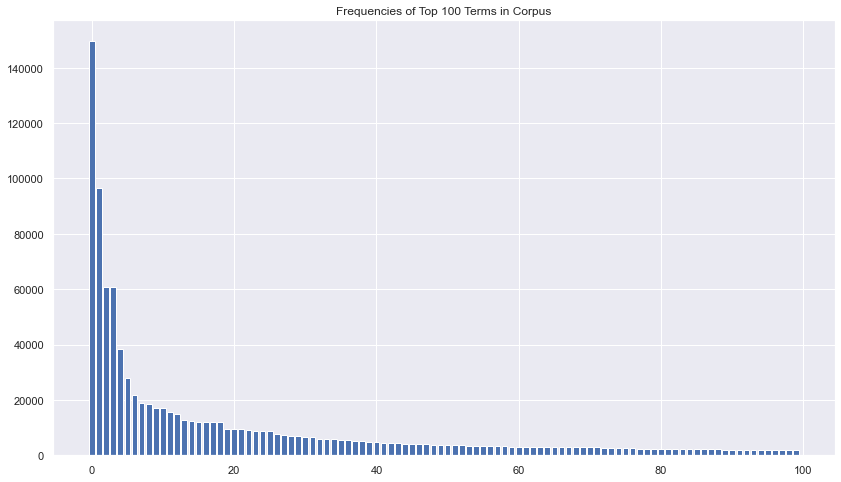

In [44]:
plt.figure(figsize=(14, 8))
plt.bar(x = range(100), height = token_counts[:100])
plt.title("Frequencies of Top 100 Terms in Corpus")
plt.show()

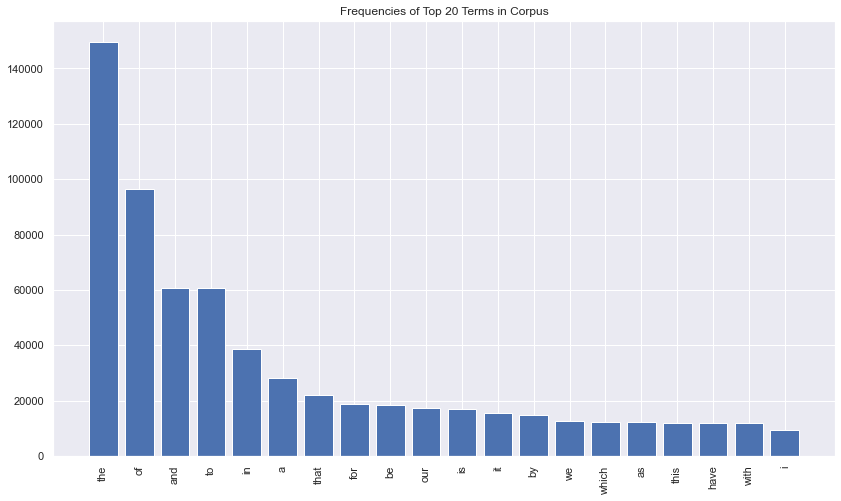

In [45]:
plt.figure(figsize=(14, 8))
plt.bar(x = types_[:20], height = token_counts[:20])
plt.xticks(rotation = 90)
plt.title("Frequencies of Top 20 Terms in Corpus")
plt.show()

## Document Frequency

Next, we'll look at document frequency: the number of documents in the corpus in which a word occurs. We'll do this using a simple, two-stage approach: we'll create a version of each document that has all duplicate words removed, and then we'll combine everything and count how many times a word occurs. The function below accepts one parameter (a string variable, intended to be a document) and splits it on whitespace, converting it to a `list`. A `list` can contain duplicates. Next, it casts the resulting list as a `set`, which removes all duplicate elements. It then casts it as a `list` again so that we can use the `.join()` method to convert it back to a string. The result of this series of transformations is that we have removed all repititions of any word. Each word occuring in a document is now represented exactly once in the new version of the document.

In [46]:
def set_of_types(document: str) -> str:
    """Returns a string with only the unique types (words) in the supplied document"""
    return " ".join(list(set(document.split())))

In [47]:
s = "this is a string that repeats some words, like string and words and some"

print(Counter(s.split())) # three types occur twice

Counter({'string': 2, 'some': 2, 'and': 2, 'this': 1, 'is': 1, 'a': 1, 'that': 1, 'repeats': 1, 'words,': 1, 'like': 1, 'words': 1})


In [48]:
s2 = set_of_types(s)

print(s2)
print()

print(Counter(s2.split())) # each type occurs only once

string words a and is words, some like this repeats that

Counter({'string': 1, 'words': 1, 'a': 1, 'and': 1, 'is': 1, 'words,': 1, 'some': 1, 'like': 1, 'this': 1, 'repeats': 1, 'that': 1})


Now, we'll use the `apply()` method to add a column to our dataframe. Specifically, we will apply the function we just defined—`set_of_types()`—to the text column, creating a version of the text with all duplicate words removed.

In [49]:
df["types"] = df.text.apply(set_of_types)
df.head()

,president,year,text,types
0,Washington,1791,fellow citizens of the senate and house of rep...,foundations expect satisfaction can miles lawl...
1,Washington,1792,fellow citizens of the senate and house of rep...,expire satisfaction can offenders attainable c...
2,Washington,1793,fellow citizens of the senate and house of rep...,vessels can complete congress who powers repor...
3,Washington,1794,fellow citizens of the senate and house of rep...,foundations miles can offenders preeminently a...
4,Washington,1795,fellow citizens of the senate and house of rep...,satisfaction can dey offenders lawless arts pa...


Now we will use `Counter()` after selecting this new column and splitting on whitespace. We'll cast this as a `dict` and store it as the variable `document_frequencies`.

In [50]:
document_frequencies = dict(Counter(" ".join(df.types).split()))

In [51]:
document_frequencies

{'foundations': 43,
 'expect': 118,
 'satisfaction': 113,
 'can': 226,
 'miles': 74,
 'lawless': 31,
 'accordingly': 61,
 'congress': 227,
 'unsuccessful': 15,
 'who': 221,
 'powers': 165,
 'spirits': 20,
 'intrepidity': 3,
 'pursuant': 32,
 'commendation': 15,
 'anticipate': 35,
 'change': 179,
 'philanthropy': 12,
 'scarcity': 17,
 'defense': 181,
 'views': 106,
 'paid': 140,
 'is': 227,
 'placed': 121,
 'variations': 4,
 'numbers': 92,
 'found': 171,
 'circumstances': 136,
 'myself': 67,
 'posts': 56,
 'indians': 98,
 'greatest': 144,
 'cooperation': 132,
 'make': 209,
 'them': 226,
 'intentioned': 3,
 'proclamation': 64,
 'still': 211,
 'its': 226,
 'current': 126,
 'any': 224,
 'returns': 59,
 'proved': 94,
 'legislature': 72,
 'of': 227,
 'laws': 196,
 'carrying': 115,
 'miscarried': 1,
 'communication': 104,
 'senate': 188,
 'intimate': 36,
 'commerce': 160,
 'applied': 114,
 'these': 226,
 'law': 202,
 'unenlightened': 2,
 'observed': 54,
 'embraced': 46,
 'solid': 33,
 'aliena

As we did for overall word frequencies, we'll create a list of tuples (namely, word—frequency pairs) sorted by document frequency and then 'unzip' that into two iterables: the words and the document frequencies. (Again, document frequency refers to the number of documents the word appears in at least once.)

In [52]:
types_and_doc_freqs = sorted(list(document_frequencies.items()), reverse = True, key = lambda x: x[1])
types_, doc_freqs = zip(*types_and_doc_freqs)

If we only looked at the first 100 words again, we wouldn't see any variation because they're all in pretty much all of the documents. We'll zoom out and look at the 500 most frequent words by document frequency. We again see a negative association between document frequency and rank based on that frequency.

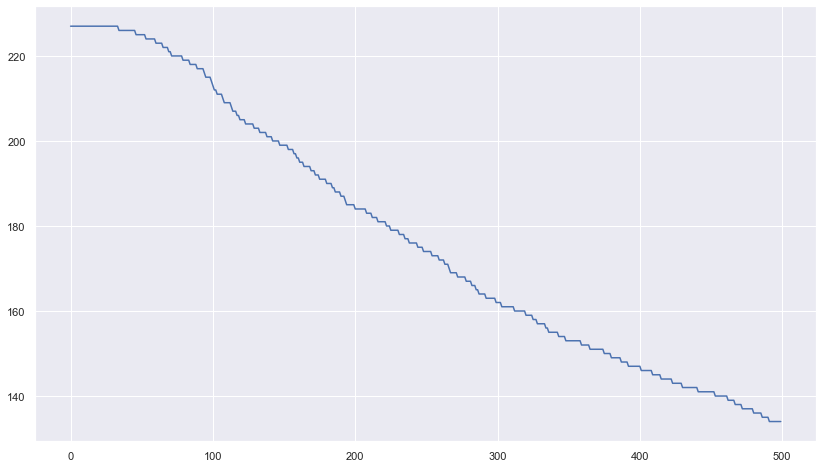

In [54]:
plt.figure(figsize=(14, 8))
plt.plot(range(500), doc_freqs[:500])
plt.title("")
plt.show()

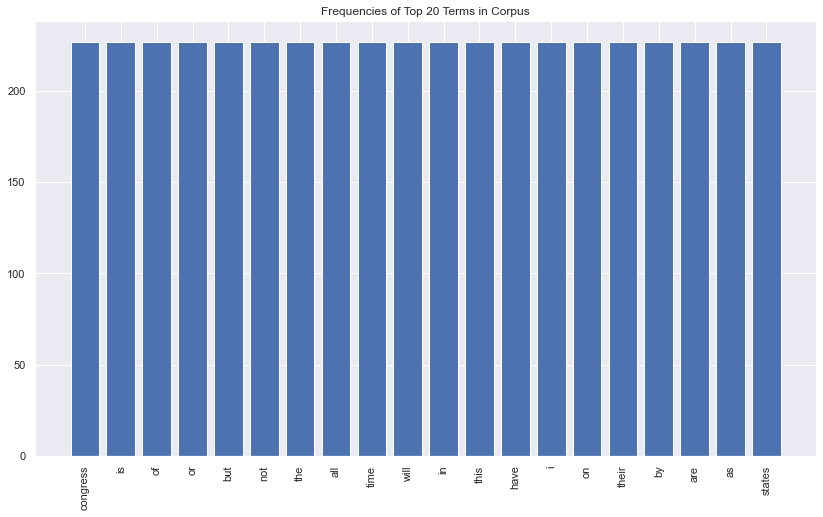

In [53]:
plt.figure(figsize=(14, 8))
plt.bar(x = types_[:20], height = doc_freqs[:20])
plt.xticks(rotation = 90)
plt.title("Frequencies of Top 20 Terms in Corpus")
plt.show()

In [55]:
df.drop(columns=["types"], inplace=True)

The cell below stores the unique words as the variable `vocabulary`. It then defines a variable `x` using a list comprehension; this contains the word frequencies (or term frequencies) in the overall corpus. The list comprehension iterates through `vocabulary` and looks up the frequency of each word in the `dict` we stored as `word_frequencies`.

We then define the variable `y` similarly, but using a list comprehension with the `dict` we saved as `document_frequencies` to create a list of document frequencies.

Finally, we can see that the two measures of frequency are positively correlated using two different correlation coefficients.

In [56]:
vocabulary, _ = zip(*types_and_counts)
vocabulary = list(vocabulary)

x = [word_frequencies[word] for word in vocabulary]
y = [document_frequencies[word] for word in vocabulary]

print("Correlation between each word's frequency in the overall corpus and its document frequency:")
print(f"Pearson's correlation coefficient: {pearsonr(x, y)[0]:.2f}")
print(f"Spearman's rank-order correlation: {spearmanr(x, y)[0]:.2f}")

Correlation between each word's frequency in the overall corpus and its document frequency:
Pearson's correlation coefficient: 0.25
Spearman's rank-order correlation: 0.98


## Pruning the Vocabulary

In [ ]:
print(len(vocabulary))

If we are interested in analyzing meaning from a corpus, in practice we will often remove words that appear only once or in only one document (which aren't the same thing!). We sometimes call these [hapaxes](https://en.wikipedia.org/wiki/Hapax_legomenon). We can't say that two documents have a word in common if only one document in the entire corpus has the word!

The cell below uses a list comprehension to create a list of words that appear in only one document, which we save as the variable `hapaxes`.

In [57]:
hapaxes = [word for word in vocabulary if document_frequencies[word] == 1]
print(len(hapaxes))

7405


We may often exclude words that appear in *every* document for similar reasons.

Let's remove hapaxes. The cell below overwrites `word_frequencies` and `document_frequencies` using a `dict comprehension` to check whether the *key* for each key—value pair in the dictionary is in our list of hapaxes. We keep every entry in these dictionaries if they occur in at least two documents.

In [58]:
word_frequencies = {key:value for key, value in word_frequencies.items() if key not in hapaxes}
document_frequencies = {key:value for key, value in document_frequencies.items() if key not in hapaxes}

assert word_frequencies.keys() == document_frequencies.keys()

types_and_counts = sorted(list(word_frequencies.items()), reverse = True, key = lambda x: x[1])
vocabulary, _ = zip(*types_and_counts)

In [59]:
print(len(vocabulary))

16040


## Assigning an Identifier to Each Speech Based on the President and Year

The function below is designed to accept a row from a dataframe, extracting the president and year. It lowercases the president's last name and then stores a function variable called `title` that unites the president and year with an underscore using an [f-string](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/). The function call returns that title.

We then create a new column by using the `apply()` method to apply this function to our dataframe.

I've also included a line of code that does this with a lambda function so you can see alternative approaches. Both work. We'll make sure they give the same result using an `assert` statement (specifically, asserting that two lists are identical), and then we'll drop one of the columns.

We'll also use a lambda function and `apply()` to create a column for the wordcount of the speech, like we did last week.

In [60]:
def remake_speech_title(row):
    pres = row["president"].lower()
    year = row["year"]
    title = f"{pres}_{year}"
    return title

df["speech_title"] = df.apply(remake_speech_title, axis=1)

df["speech_title_lambda"] = df.apply(lambda row: f"{row['president'].lower()}_{row['year']}", axis=1)

df["wordcount"] = df.text.apply(lambda x: len(x.split()))

df.head()

,president,year,text,speech_title,speech_title_lambda,wordcount
0,Washington,1791,fellow citizens of the senate and house of rep...,washington_1791,washington_1791,2304
1,Washington,1792,fellow citizens of the senate and house of rep...,washington_1792,washington_1792,2092
2,Washington,1793,fellow citizens of the senate and house of rep...,washington_1793,washington_1793,1965
3,Washington,1794,fellow citizens of the senate and house of rep...,washington_1794,washington_1794,2916
4,Washington,1795,fellow citizens of the senate and house of rep...,washington_1795,washington_1795,1988


In [61]:
assert df.speech_title.tolist()==df.speech_title_lambda.tolist()

In [62]:
df.drop(columns="speech_title_lambda", inplace=True)
df.head()

,president,year,text,speech_title,wordcount
0,Washington,1791,fellow citizens of the senate and house of rep...,washington_1791,2304
1,Washington,1792,fellow citizens of the senate and house of rep...,washington_1792,2092
2,Washington,1793,fellow citizens of the senate and house of rep...,washington_1793,1965
3,Washington,1794,fellow citizens of the senate and house of rep...,washington_1794,2916
4,Washington,1795,fellow citizens of the senate and house of rep...,washington_1795,1988


[]

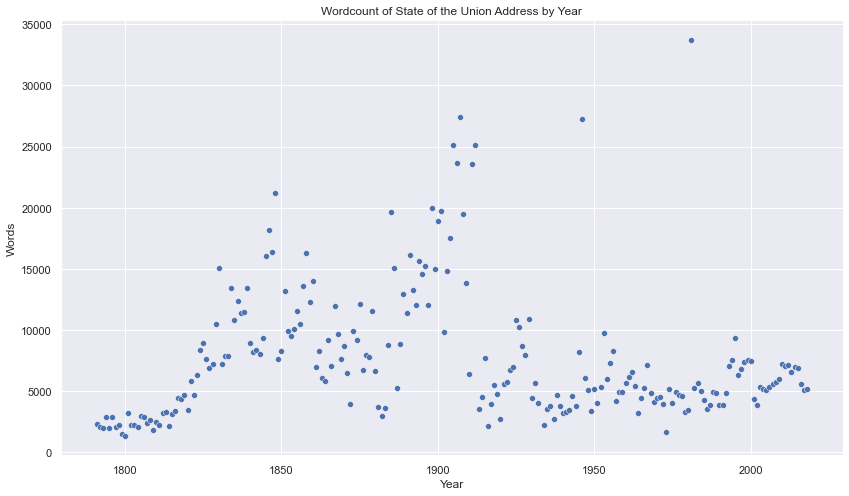

In [63]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x = "year", y = "wordcount", data = df)
plt.title("Wordcount of State of the Union Address by Year")
plt.xlabel("Year")
plt.ylabel("Words")
plt.plot()

We can use the `max()` method to identify the wordcount of the longest speech, and then the next line to identify the speech with that exact wordcount.

In [64]:
df.wordcount.max()

33704

In [65]:
df[df.wordcount.eq(df.wordcount.max())]

,president,year,text,speech_title,wordcount
189,Carter,1981,to the congress of the united states the sta...,carter_1981,33704


## Document-Term Matrix

The first step to comparing documents based on the frequencies of terms is to construct a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). Simply put, we will have a row for each document and a column for each individual type (i.e., unique word). The cells will include the number of times that word occurs in that document.

The code below uses `copy.copy()` to create a copy of our original dataframe, `df`, that won't change if `df` changes. See Nick Parlante's guide on this point [here](https://cs.stanford.edu/people/nick/py/python-nocopy.html).

In [67]:
x = [1, 2, 3]
y = x

print(x)
print(y)

x.append(4)
print(y) # y changes when x does, even though we changed x after creating y

[1, 2, 3]
[1, 2, 3]
[1, 2, 3, 4]


In [68]:
dtm = copy.copy(df)
dtm.text = dtm.text.apply(str.split)
dtm = dtm[["speech_title", "text"]]
dtm.head()

,speech_title,text
0,washington_1791,"[fellow, citizens, of, the, senate, and, house..."
1,washington_1792,"[fellow, citizens, of, the, senate, and, house..."
2,washington_1793,"[fellow, citizens, of, the, senate, and, house..."
3,washington_1794,"[fellow, citizens, of, the, senate, and, house..."
4,washington_1795,"[fellow, citizens, of, the, senate, and, house..."


The function below takes a document (as a list of words) and our vocabulary (also as a list of words) and returns a list of the term frequencies—the frequency of each word *within the document*, rather than in the corpus overall.

In [69]:
def term_frequency(doc: list, vocab: list) -> list:
    """Returns a list of term frequencies, given a document and vocab list"""
    return [doc.count(term) for term in vocab]

In [70]:
s = ["the", "cat", "in", "the", "hat"]

term_frequency(s, vocabulary[:10])

[2, 0, 0, 0, 1, 0, 0, 0, 0, 0]

The cell below prints the the first 10 words in our vocabulary list on one line and the term frequencies of those 10 words in the first speech in the corpus on the second line. 

In [71]:
print(vocabulary[:10])

for idx, row in dtm.iterrows():
    print(term_frequency(row.text, vocabulary[:10]))
    break

('the', 'of', 'and', 'to', 'in', 'a', 'that', 'for', 'be', 'our')
[242, 159, 73, 88, 41, 42, 32, 22, 34, 5]


Because we have such a large vocabulary still, we are going to use a subset of 3,000 words (an arbitrary number) for the examples below. One justification for this is that it will reduce the burden to compute everything; another is that most words, as we have seen, are rare, and we are keeping the 3,000 most frequent words.

In [72]:
vocab_subset = vocabulary[:3000]

The cell below uses the `apply()` method with a lambda function, with a twist: rather than working on a single variable, it's going to work through all 3,000 words in `vocab_subset`—creating 3,000 columns.

There's a lot of overhead and this may not be the best way to do it—see  [this blog post](https://ys-l.github.io/posts/2015/08/28/how-not-to-use-pandas-apply/), for instance, about the dangers of using `apply()` in this way—but I timed this approach and it took less than half the time of a loop-based method. We are saving it as a new object, `dtm_counts`, and will then merge it with the columns we saved in our copy of `df`. If we add the new columns directly to our copy of `df`, `pandas` will give us many warnings (potentially 3,000!).

In [73]:
%%time

dtm_counts = dtm.text.apply(lambda x: pd.Series(term_frequency(x, vocab_subset)))

dtm_counts.head()

CPU times: total: 1min 9s
Wall time: 1min 9s


,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,242,159,73,88,41,42,32,22,34,5,...,0,0,0,0,0,0,0,0,0,0
1,195,139,56,88,48,32,24,30,29,11,...,0,0,0,0,0,0,0,0,0,0
2,180,132,49,74,26,34,12,23,43,16,...,0,0,0,0,0,0,0,0,0,0
3,273,187,86,138,36,48,39,14,36,22,...,0,0,0,0,0,0,0,0,0,0
4,174,130,73,64,27,33,27,22,22,43,...,0,0,0,0,0,0,0,0,0,0


In [80]:
dtm_counts.shape

(227, 3000)

Note that the column names are 0 through 2999. These are the indices of the columns. Below, we uses a `dict comprehension` to create a mapping of our vocabulary words to their indices (i.e., the first one is 0, the second is 1, and so on). We then rename the columns in `dtm_counts` using this dictionary. The "mapper" argument in the `rename()` method accepts the dictionary for this purpose. It simply finds columns that match keys in the dictionary (like 0) and replaces them with the value in the dictionary for that key (like "the").

In [74]:
vocab_subset[0]

'the'

In [78]:
# index_to_vocab_word_dict

In [76]:
index_to_vocab_word_dict = {i:vocab_subset[i] for i in range(len(vocab_subset))}

dtm_counts.rename(mapper=index_to_vocab_word_dict, axis=1, inplace=True)

In [79]:
dtm_counts.head()

,the,of,and,to,in,a,that,for,be,our,...,exempt,adjournment,residing,useless,refuse,adding,rejected,liquidation,formation,netherlands
0,242,159,73,88,41,42,32,22,34,5,...,0,0,0,0,0,0,0,0,0,0
1,195,139,56,88,48,32,24,30,29,11,...,0,0,0,0,0,0,0,0,0,0
2,180,132,49,74,26,34,12,23,43,16,...,0,0,0,0,0,0,0,0,0,0
3,273,187,86,138,36,48,39,14,36,22,...,0,0,0,0,0,0,0,0,0,0
4,174,130,73,64,27,33,27,22,22,43,...,0,0,0,0,0,0,0,0,0,0


In [81]:
dtm = pd.concat([dtm, dtm_counts], axis=1)
dtm.head()

,speech_title,text,the,of,and,to,in,a,that,for,...,exempt,adjournment,residing,useless,refuse,adding,rejected,liquidation,formation,netherlands
0,washington_1791,"[fellow, citizens, of, the, senate, and, house...",242,159,73,88,41,42,32,22,...,0,0,0,0,0,0,0,0,0,0
1,washington_1792,"[fellow, citizens, of, the, senate, and, house...",195,139,56,88,48,32,24,30,...,0,0,0,0,0,0,0,0,0,0
2,washington_1793,"[fellow, citizens, of, the, senate, and, house...",180,132,49,74,26,34,12,23,...,0,0,0,0,0,0,0,0,0,0
3,washington_1794,"[fellow, citizens, of, the, senate, and, house...",273,187,86,138,36,48,39,14,...,0,0,0,0,0,0,0,0,0,0
4,washington_1795,"[fellow, citizens, of, the, senate, and, house...",174,130,73,64,27,33,27,22,...,0,0,0,0,0,0,0,0,0,0


In [82]:
dtm.drop(columns="text", inplace=True)
dtm.set_index("speech_title", inplace=True)

In [83]:
dtm.head()

,the,of,and,to,in,a,that,for,be,our,...,exempt,adjournment,residing,useless,refuse,adding,rejected,liquidation,formation,netherlands
speech_title,,,,,,,,,,,,,,,,,,,,,
washington_1791,242,159,73,88,41,42,32,22,34,5,...,0,0,0,0,0,0,0,0,0,0
washington_1792,195,139,56,88,48,32,24,30,29,11,...,0,0,0,0,0,0,0,0,0,0
washington_1793,180,132,49,74,26,34,12,23,43,16,...,0,0,0,0,0,0,0,0,0,0
washington_1794,273,187,86,138,36,48,39,14,36,22,...,0,0,0,0,0,0,0,0,0,0
washington_1795,174,130,73,64,27,33,27,22,22,43,...,0,0,0,0,0,0,0,0,0,0


In [84]:
dtm.shape

(227, 3000)

## Plotting Speeches in a 2D Space using Principal Component Analysis

We will talk more about dimensionality reduction later in this class. If you are not familiar with [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), that's okay!

The problem we are trying to solve is that we have represented the speeches as vectors with a length of 3,000 (i.e., term frequencies for 3,000 terms). We can really only visualize stuff in two or three dimensions. PCA is one method for *reducing dimensionality*. It isn't perfect, or even necessarily the best approach, but we can use it to plot the locations of the speeches in a two-dimensional space. First, we are going to create another copy of our document-term matrix, `dtm_std`, in which we will standardize all of the frequencies by subtracting the mean and dividing by the standard deviation. This is one form of [normalization](https://en.wikipedia.org/wiki/Normalization_(statistics). We will standardize things later for ease of interpretation; here we are doing this only to facilitate PCA.

As we discussed before, `numpy` (here imported with the alias `np`) computes standard deviations by dividing by *n*, not *n*-1 as R, Stata, and even various other Python modules do. The `ddof` argument allows us to adjust for this.

In [85]:
dtm_std = copy.copy(dtm)
titles = dtm_std.index # we create an iterable with all the titles...
dtm_std = dtm_std.to_numpy() # ...and then convert dtm_std to a numpy array

sd = np.std(dtm.to_numpy(), ddof = 1, axis = None)

dtm_std = dtm_std - dtm_std.mean()
dtm_std = dtm_std/sd

In [86]:
dtm_std

array([[10.90212842,  7.12614031,  3.21367071, ..., -0.10737907,
        -0.10737907, -0.10737907],
       [ 8.76391829,  6.21626366,  2.44027555, ..., -0.10737907,
        -0.10737907, -0.10737907],
       [ 8.0815108 ,  5.89780683,  2.12181873, ..., -0.10737907,
        -0.10737907, -0.10737907],
       ...,
       [11.94848657,  6.03428833,  8.49095529, ..., -0.10737907,
        -0.10737907, -0.10737907],
       [10.53817776,  6.67120199,  9.53731344, ..., -0.10737907,
        -0.10737907, -0.10737907],
       [10.21972093,  5.44286851,  9.17336278, ..., -0.10737907,
        -0.10737907, -0.10737907]])

In [87]:
dtm_std.mean() # this is basically zero, just never perfectly zero

-3.547496771783173e-18

Now we'll implement PCA and do some basic visualizations before turning to TF-IDF weighting to try to improve the results. We only need two dimensions for the visualization, but in practice you might run PCA with more components and try to select the best set of results and only *then* create a plot using the first two dimensions (or three, if you're creating a 3D visualization).

In [88]:
pca = PCA(n_components=2)
components = pca.fit_transform(dtm_std)

pca_df = pd.DataFrame(data = components, columns = ["component1", "component2"])

In [89]:
pca_df["title"] = titles
pca_df[["president", "year"]] = pca_df.title.apply(lambda x: pd.Series(x.split("_")))
pca_df.year = pca_df.year.apply(int)
pca_df

,component1,component2,title,president,year
0,-27.784934,-5.191859,washington_1791,washington,1791
1,-30.079653,-4.574890,washington_1792,washington,1792
2,-31.119900,-4.951512,washington_1793,washington,1793
3,-25.231326,-4.559162,washington_1794,washington,1794
4,-31.283500,-4.141323,washington_1795,washington,1795
...,...,...,...,...,...
222,-20.279265,10.241307,obama_2014,obama,2014
223,-20.889429,11.899960,obama_2015,obama,2015
224,-23.234453,7.194619,obama_2016,obama,2016
225,-24.411669,5.755875,trump_2017,trump,2017


The variable `mask` we define below returns `True` or `False` for each row based on the condition that the year is greater than 2000. We're simply filtering out some of the data points so we can see what's going on more clearly with the more recent State of the Union addresses.

We can see Trump's addresses are close to one another in this space, but they are in the middle of George W. Bush's. Obama's speeches appear to be clustered on their own, but they aren't super distant from the others.

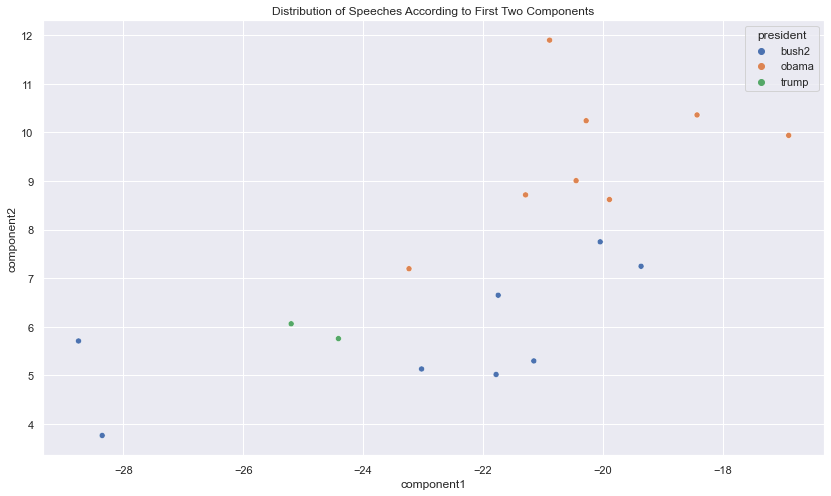

In [90]:
mask = pca_df["year"] > 2000

label_points = False

plt.figure(figsize=(14, 8))
sns_plot = sns.scatterplot(x = "component1", y = "component2", data = pca_df[mask], hue="president")
plt.title("Distribution of Speeches According to First Two Components")
if label_points:
    for idx, row in pca_df[mask].iterrows():
        sns_plot.text(x = row["component1"], y = row["component2"], s = row["title"])
plt.show()

The function below will help us create a column for the decade so we can group speeches by decade for visualization purposes.

In [91]:
def return_decade(year: int) -> str:
    """Given a year, returns the decade as a string"""
    return str(year)[:-1] + "0s"

In [92]:
return_decade(1984)

'1980s'

In [93]:
pca_df["decade"] = pca_df.year.apply(return_decade)

In [94]:
pca_df.head()

,component1,component2,title,president,year,decade
0,-27.784934,-5.191859,washington_1791,washington,1791,1790s
1,-30.079653,-4.574890,washington_1792,washington,1792,1790s
2,-31.119900,-4.951512,washington_1793,washington,1793,1790s
3,-25.231326,-4.559162,washington_1794,washington,1794,1790s
4,-31.283500,-4.141323,washington_1795,washington,1795,1790s


We plot the results below. With PCA, we might sometimes have some intuitions about what the components (latent variables) capture, but we never really know for sure. In this instance, we shouldn't expect much because, so far, we are only looking at raw word counts. We do see that the more recent speeches cluster together, but they are also near the earliest, with speeches from he mid-1800s to mid-1900s widely dispersed along the first component.

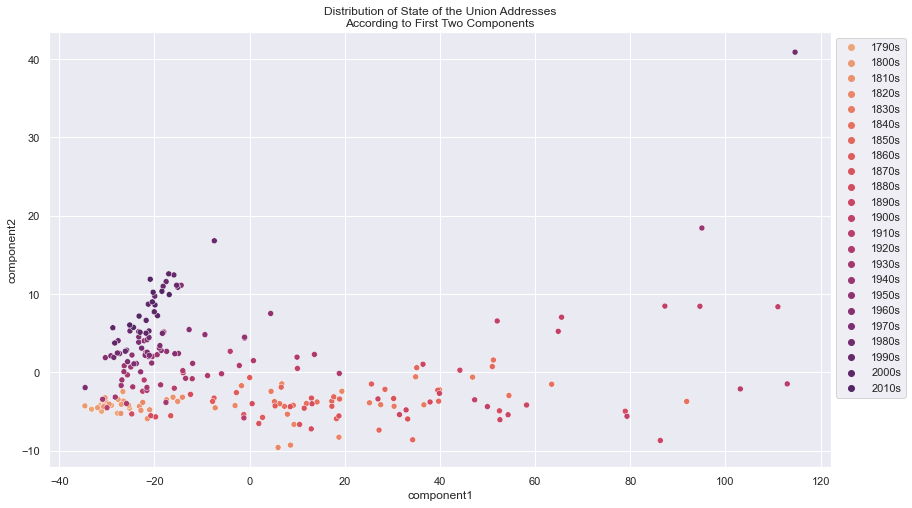

In [95]:
plt.figure(figsize=(14, 8))

sns.scatterplot(x = "component1", y = "component2", data = pca_df, hue="decade", palette="flare")
plt.title("Distribution of State of the Union Addresses\nAccording to First Two Components")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Using TF-IDF to Compare Documents

Let's see if things improve if we use [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighting. This take the term frequencies we've just employed and weights them by the inverse of document frequency of the given term. Since document frequency is based on the whole corpus, this approach links document-level information term frequencies in the document) with corpus-level information (document frequencies of the vocabulary). If two speeches use the same common word a lot, they'll seem more similar regardless. With tf-idf weighting, however, two speeches that use the same *rare* word will seem even more similar. Weighting with tf-idf makes rare words matter more.

We define three helper funtions below. `compute_idf` computes the inverse document frequency, given the number of documents (`N`) and the document frequency of a word. `compute_tfidf` uses the frequency of a term within a document and the inverse document frequency of the term overall to compute the tf-idf score for a single word for a single document. `compute_all_tfidf` computes the tf-idf scores for all words in a list of vocabulary words for a single document by applying `compute_tfidf` repeatedly.

We define the variable `N` using the `shape()` method with `[0]` to select the first element, which is the number of rows (documents) in the dataframe.

`idf_dict` is a `dict` we define with a `dict comprehension` using the compute_idf() function we just defined while iterating through all of the key—value pairs in `document_frequencies.items()`.

In [96]:
def compute_idf(N: int, doc_freq: int) -> float:
    """Given the number of documents, N, and the document frequency, return the
    inverse document frequency (IDF)"""
    return np.log10(N/(1 + doc_freq))


def compute_tfidf(doc: list, word: str) -> float:
    """Given a document and a vocabulary word, returns the tfidf score for that word for that document"""
    term_freq = np.log(1 + doc.count(word))
    idf = idf_dict[word]
    return term_freq * idf


def compute_all_tfidf(doc: list, vocab: list) -> list:
    """Given a document and a list of words, returns the tfidf scores for each word for that document"""
    return [compute_tfidf(doc, word) for word in vocab]
    
    
N = dtm.shape[0]
    
idf_dict = {word:compute_idf(N, frequency) for word, frequency in document_frequencies.items()}

Now we will make a copy of our original dataframe. We will call it `weighted_dtm` because it will be based on a document-term matrix, but we will weight the values using tf-idf instead of the raw counts.

In [97]:
weighted_dtm = copy.copy(df)
weighted_dtm.text = weighted_dtm.text.apply(str.split)
weighted_dtm = weighted_dtm[["speech_title", "text"]]
weighted_dtm.head()

,speech_title,text
0,washington_1791,"[fellow, citizens, of, the, senate, and, house..."
1,washington_1792,"[fellow, citizens, of, the, senate, and, house..."
2,washington_1793,"[fellow, citizens, of, the, senate, and, house..."
3,washington_1794,"[fellow, citizens, of, the, senate, and, house..."
4,washington_1795,"[fellow, citizens, of, the, senate, and, house..."


The cell below again uses `apply()` to create 3,000 columns in a new object, `tfidf_scores`, that we will merge with the dataframe we just created. Everything we discussed the first time we did this applies. We will reuse `index_to_vocab_word_dict` because the vocabulary is in the same order.

In [98]:
%%time

tfidf_scores = weighted_dtm.text.apply(lambda x: pd.Series(compute_all_tfidf(x, vocab_subset)))

tfidf_scores.head()

CPU times: total: 1min 13s
Wall time: 1min 13s


,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.010486,-0.009688,-0.008216,-0.008569,-0.007135,-0.007180,-0.006675,-0.005986,-0.006787,-0.003420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.010076,-0.009434,-0.007718,-0.008569,-0.007429,-0.006675,-0.006145,-0.006555,-0.006493,-0.004744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.009924,-0.009336,-0.007468,-0.008242,-0.006292,-0.006787,-0.004896,-0.006067,-0.007224,-0.005409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.010715,-0.009996,-0.008525,-0.009420,-0.006893,-0.007429,-0.007042,-0.005170,-0.006893,-0.005986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.009860,-0.009307,-0.008216,-0.007969,-0.006361,-0.006732,-0.006361,-0.005986,-0.005986,-0.007224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
tfidf_scores.rename(mapper=index_to_vocab_word_dict, axis=1, inplace=True)
weighted_dtm = pd.concat([weighted_dtm, tfidf_scores], axis=1)

In [100]:
weighted_dtm.drop(columns="text", inplace=True)
weighted_dtm.head()

,speech_title,the,of,and,to,in,a,that,for,be,...,exempt,adjournment,residing,useless,refuse,adding,rejected,liquidation,formation,netherlands
0,washington_1791,-0.010486,-0.009688,-0.008216,-0.008569,-0.007135,-0.007180,-0.006675,-0.005986,-0.006787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,washington_1792,-0.010076,-0.009434,-0.007718,-0.008569,-0.007429,-0.006675,-0.006145,-0.006555,-0.006493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,washington_1793,-0.009924,-0.009336,-0.007468,-0.008242,-0.006292,-0.006787,-0.004896,-0.006067,-0.007224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,washington_1794,-0.010715,-0.009996,-0.008525,-0.009420,-0.006893,-0.007429,-0.007042,-0.005170,-0.006893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,washington_1795,-0.009860,-0.009307,-0.008216,-0.007969,-0.006361,-0.006732,-0.006361,-0.005986,-0.005986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
document_frequencies["netherlands"]

32

In [111]:
weighted_dtm.size

681000

Now we will try PCA with the tf-idf weights!

In [101]:
weighted_dtm.set_index("speech_title", inplace=True)
titles = weighted_dtm.index
weighted_dtm = weighted_dtm.to_numpy()

sd = np.std(weighted_dtm, ddof = 1, axis = None)

weighted_dtm = weighted_dtm - weighted_dtm.mean()
weighted_dtm = weighted_dtm/sd

In [102]:
tfidf_pca = PCA(n_components=2)
components = tfidf_pca.fit_transform(weighted_dtm)

tfidf_pca_df = pd.DataFrame(data = components, columns = ["component1", "component2"])
tfidf_pca_df["title"] = titles
tfidf_pca_df[["president", "year"]] = tfidf_pca_df.title.apply(lambda x: pd.Series(x.split("_")))
tfidf_pca_df.year = tfidf_pca_df.year.apply(int)
tfidf_pca_df

,component1,component2,title,president,year
0,-12.310544,-18.867454,washington_1791,washington,1791
1,-12.883375,-18.798862,washington_1792,washington,1792
2,-13.222416,-17.843384,washington_1793,washington,1793
3,-10.669842,-17.052155,washington_1794,washington,1794
4,-13.489575,-19.024879,washington_1795,washington,1795
...,...,...,...,...,...
222,-27.311317,26.454436,obama_2014,obama,2014
223,-27.270959,21.378254,obama_2015,obama,2015
224,-26.776966,16.128773,obama_2016,obama,2016
225,-22.968258,8.205055,trump_2017,trump,2017


In contrast to the visualization based on term frequencies alone, we see that the Obama and Trump speeches are farther apart, with Bush's speeches in between. Obama's speeches appear to be much more separated from the others.

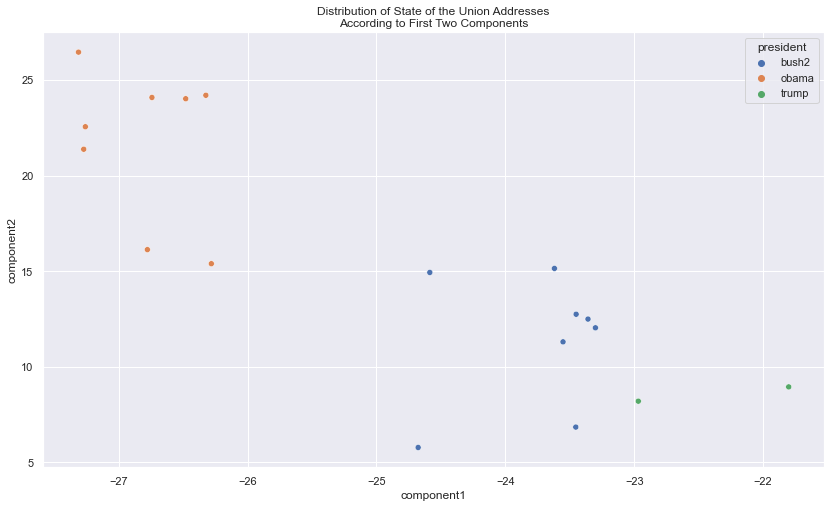

In [103]:
mask = tfidf_pca_df["year"] > 2000
tfidf_pca_df[mask]

label_points = False

plt.figure(figsize=(14, 8))
sns_plot = sns.scatterplot(x = "component1", y = "component2", data = tfidf_pca_df[mask], hue="president")
plt.title("Distribution of State of the Union Addresses\nAccording to First Two Components")
if label_points:
    for idx, row in tfidf_pca_df[mask].iterrows():
        sns_plot.text(x = row["component1"], y = row["component2"], s = row["title"])
plt.show()

In [104]:
tfidf_pca_df["decade"] = tfidf_pca_df.year.apply(return_decade)

In [105]:
tfidf_pca_df

,component1,component2,title,president,year,decade
0,-12.310544,-18.867454,washington_1791,washington,1791,1790s
1,-12.883375,-18.798862,washington_1792,washington,1792,1790s
2,-13.222416,-17.843384,washington_1793,washington,1793,1790s
3,-10.669842,-17.052155,washington_1794,washington,1794,1790s
4,-13.489575,-19.024879,washington_1795,washington,1795,1790s
...,...,...,...,...,...,...
222,-27.311317,26.454436,obama_2014,obama,2014,2010s
223,-27.270959,21.378254,obama_2015,obama,2015,2010s
224,-26.776966,16.128773,obama_2016,obama,2016,2010s
225,-22.968258,8.205055,trump_2017,trump,2017,2010s


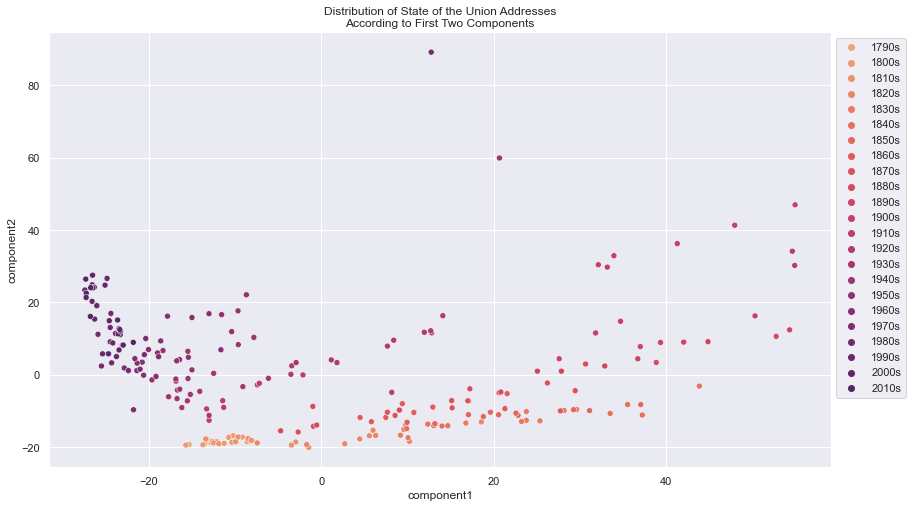

In [106]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x = "component1", y = "component2", data = tfidf_pca_df, hue="decade", palette="flare")
plt.title("Distribution of State of the Union Addresses\nAccording to First Two Components")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

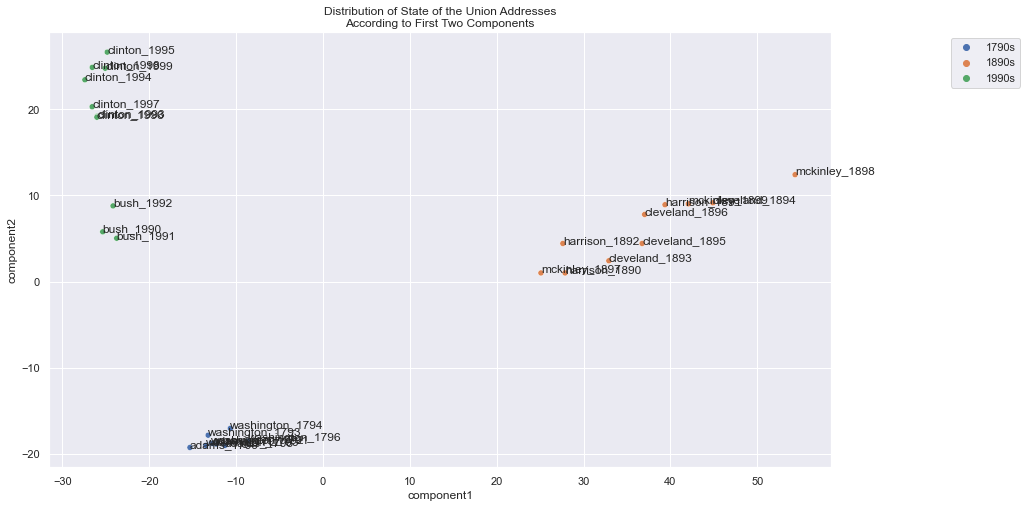

In [108]:
mask = tfidf_pca_df.decade.isin(["1790s", "1890s", "1990s"])

label_points = True

plt.figure(figsize=(14, 8))
sns_plot = sns.scatterplot(x = "component1", y = "component2", data = tfidf_pca_df[mask], hue="decade")
plt.title("Distribution of State of the Union Addresses\nAccording to First Two Components")
plt.legend(bbox_to_anchor=(1.25, 1))
if label_points:
    for idx, row in tfidf_pca_df[mask].iterrows():
        sns_plot.text(x = row["component1"], y = row["component2"], s = row["title"])
plt.show()

## Sparse versus Dense Vectors

In [109]:
print(f"Number of non-zero values in the (truncated) document-term matrix: {np.count_nonzero(dtm):,}")
print(f"Number of entries in the (truncated) document-term matrix: {dtm.size:,}")
print(f"{np.count_nonzero(dtm)/dtm.size * 100:.0f}% of entries are zeros, and that's based on "
      "the 3,000 most frequent words!")

Number of non-zero values in the (truncated) document-term matrix: 259,630
Number of entries in the (truncated) document-term matrix: 681,000
38% of entries are zeros, and that's based on the 3,000 most frequent words!


We will discuss tf-idf more when we talk about document similarity, but there are many other ways of representing words, documents, or parts of documents as vectors. What we have done in this notebook is create what are considered sparse vectors because words fail to co-occur at such a high rate: there are a lot of dimensions, there are many zeros, and in general cell counts in a document-term matrix will be low. Dimensionality reduction is a core part of the approaches we will take going forward, including the use of 'dense' vectors, which are based on powerful algorithms that produce better representations of words or documents using fewer dimensions.